# Bibliotecas

Só o básico

> Usando nltk para filtrar palavras irrelevantes e posteriormente usar o módulo `profanity_filter` pra remover potenciais palavrões :P

In [87]:
%pip install -r requirements.txt

You should consider upgrading via the '/home/pesadaum/Documentos/notebook/word_cloud/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [88]:
import numpy as np
import nltk
from PIL import Image
from scipy.ndimage import gaussian_gradient_magnitude
from wordcloud import WordCloud, ImageColorGenerator
# from profanity_filter import ProfanityFilter

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pesadaum/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Lendo o texto

Por hora é uma história aleatória, depois o texto vai ser coletado via forms

In [89]:
with open('./data/text.txt') as f:
  raw_text = f.readlines()
  text = ' '.join([str(i) for i in raw_text]).replace('\n', '')

stops = nltk.corpus.stopwords.words('portuguese')
stops += nltk.corpus.stopwords.words('english')

len(text), len(stops),

(80340, 383)

# Lendo a imagem

Não é nenhuma mágica (até agora), é só ler a imagem e transformar num array numpy com formato ou *shape* (x, y, 3). Qualquer função de ler imagem serve.

A linha seguinte (`img = img[::3,::3]`) reduz a qualidade da imagem, é útil pra fazer o código rodar mais rápido.

In [90]:
img = np.array(Image.open('./img_in/unifei_logo.png'))
img = img[::3,::3]

# Processando as bordas

Usando a média do gradiente de Gauss dá pra filtrar a imagem legal e usar o realce das bordas como os eixos para as trocas de cor. A função pode parecer meio maluca à primeira vista. E é mesmo. Vamos ao passo a passo:

1. Normaliza as componentes de cor da imagem para cada canal de cor RGB (aquela parte que divide por 255 e fala `for i in range(3)` que é pra cada canal de cor) e joga an variável `gradient`
2. Tira a média do resultado e joga na variável `edges` 
3. Copia os valores de cor da imagem pra variável `img_mask`
4. Se para cada valor de `edges` for maior que o gatilho escolhido (`mask_threshold`), a imagem terá cor. Caso contrário, não terá.
5. Ufa


In [91]:
gradient =  [gaussian_gradient_magnitude(img[:, :, i] / 255., sigma=1) for i in range(3)]
edges = np.mean(gradient, axis=0)

mask_thresh = 0.008
img_mask = img.copy()
img_mask[img_mask.sum(axis=2) == 0] = 255
img_mask[edges > mask_thresh] = 255

# Gerando o WordCloud

Processar a imagem tá praticamente feito, agora basta gerar a nuvem. Algumas considerações:

- rel_scaling: não fez diferença evidente trocar para 0 ou para 1
- max_words: com umas 2000 palavras já dá um resultado aceitável, dá pra usar o comprimento (em caracteres) do próprio texto pra deixar esse valor no automático
  * 5000 palavras demora uns 3m então melhor ir com cuidado 
- font: só especificar o caminho da fonte pro arquivo `.ttf`
- scale: aumenta a escala da imagem. Por padrão e 1 e produz uma imagem de $1000 \times 1000$. Aumentar a escala também melhora a qualidade (e o tamanho do png)

In [92]:
rel_scaling = 1 
max_words = 5000
font = './Exo_2/Exo2-VariableFont_wght.ttf'
scale = 1

wc = WordCloud(
    mask=img_mask, 
    max_words=max_words,
    font_path=font,
    stopwords=stops,
    scale=scale,
    mode="RGBA",
    background_color=None,
    max_font_size=180,
    random_state=2,
    relative_scaling='auto',
    min_font_size=1, 
    repeat=True)

wc.generate(text)

# Colorindo o WordCloud

Por padrão, a saída do wordcloud é binária (com cor, sem cor, <strike>cor sim cor não</strike>) então usamos uma função mão na roda que extrai as cores sem muito mistério

In [93]:
image_colors = ImageColorGenerator(img)
wc.recolor(color_func=image_colors)

# Salvando o arquivo

Falta só salvar o arquivo agora. O PNG tem uma qualidade suficientemente boa mas como esse pessoal que faz o kit é maluco podemos salvar em SVG também. 

- Para salvar em PNG é só usar a função do próprio módulo `to_file('nome_do_arquivo.png')`. Essa função não suporta SVG nativamente, então a gente usa gambiarra:
- Para salvar em SVG a gente usa a função de converter pra PNG (que retorna uma string) e grava essa string num arquivo. Voillá! Temos um Wordcloud!

In [95]:
wc_svg = wc.to_svg(embed_font=True)
with open('./img_out/wc.svg', 'w') as f:
    f.write(wc_svg)

[Text(0.5, 1.0, 'Wordcloud gerado'), None]

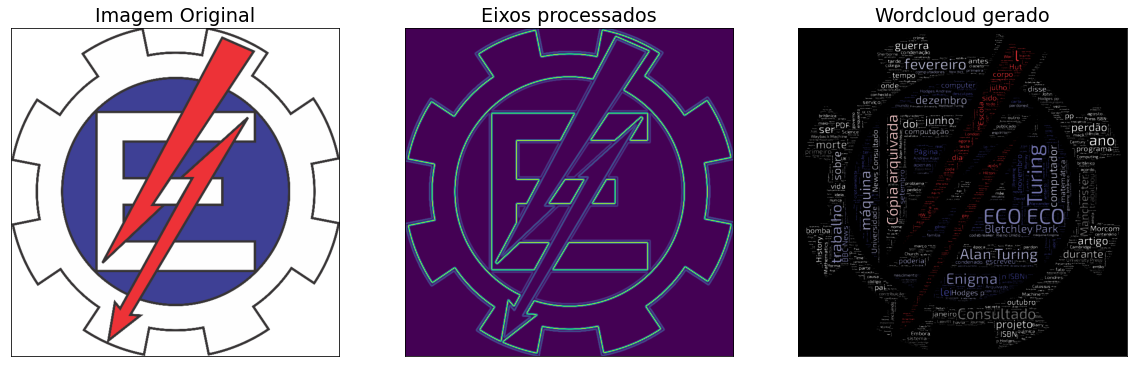

In [96]:
import matplotlib.pyplot as plt

plt.rc('font', size=16)

f, ax = plt.subplots(ncols=3, figsize=(20, 10))

ax[0].imshow(img)
ax[1].imshow(edges)
ax[2].imshow(wc, interpolation='bilinear')

for i in ax:
    i.set(
        xticks=[], yticks=[]
    )

ax[0].set(
    title='Imagem Original'
)

ax[1].set(
    title='Eixos processados'
)

ax[2].set(
    title='Wordcloud gerado',
    facecolor='black'
)


![](./img_out/wc_color_dummy.png)